In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch

# 创建数据库引擎
table_hk_daily = "hk_customs_daily"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
query = "select global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine).astype('float')
original_data = data.copy()

Data Minmax Scaler

In [3]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
if use_standard_scaler:
    for column in data.columns:
        if column not in ['date']:
            scaler = MinMaxScaler()
            data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).reshape(
                -1)
            scalers[column] = scaler

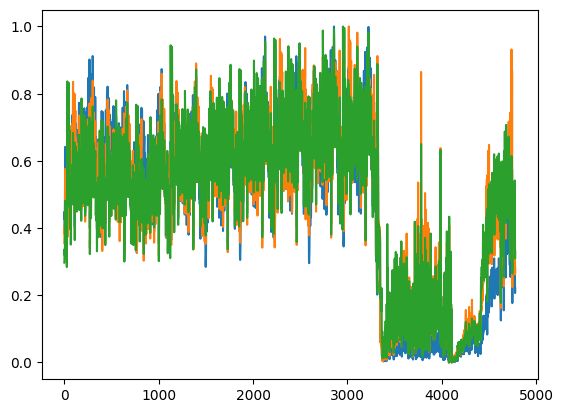

In [4]:
plt.plot(data)
plt.show()

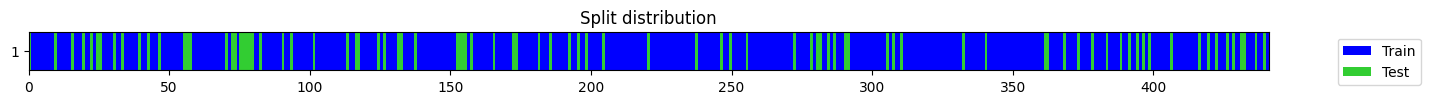

((441, 3, 365), (441, 3, 10))

In [46]:
from tsai.data.core import TSDatasets, TSDataLoaders
from tsai.data.validation import get_splits
from tsai.data.preparation import SlidingWindow
from tsai.data.core import TSForecasting

window_length = 365
stride = horizon = 10  # window move only one step forward, also means len(X)=len(data)
n_vars = 3

X, y = SlidingWindow(window_length, stride=stride, horizon=horizon, get_x=None, get_y=None)(data.values)
splits = get_splits(y, valid_size=.2, stratify=False, random_state=42, shuffle=True)
dsets = TSDatasets(X, y, tfms=[None, [TSForecasting()]], splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid)
(X.shape, y.shape)

# train the model (using TSAI sklearn like API)

SuggestedLRs(valley=4.365158383734524e-05)

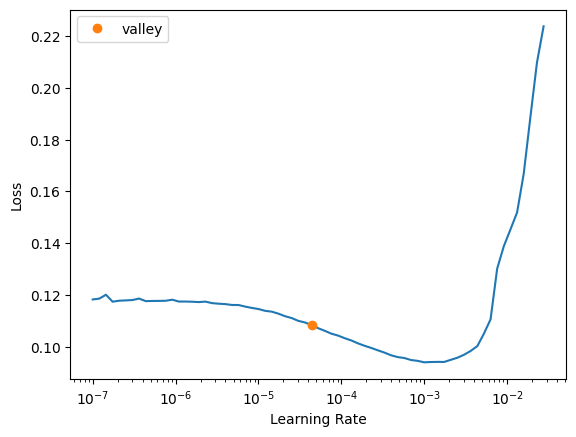

In [55]:
from torch.nn.functional import mse_loss
from tsai.data.core import TSForecasting
from tsai.tslearner import TSForecaster
from torch import nn
from tsai.callback.core import ShowGraphCallback2
from fastai.metrics import mae, rmse
from fastai.losses import MSELossFlat, L1LossFlat
from tsai.models.TST import TST
from tsai.models.PatchTST import PatchTST

# # model = None = ResNet
# model = TST(c_in=dls.vars,
#             c_out=horizon*n_vars,
#             seq_len=dls.len,
#             max_seq_len=dls.len,
#             n_layers=3,
#             d_model=128,
#             n_heads=16,
#             d_k=32,
#             d_v=64,
#             dropout=0.1)

model = PatchTST(
    c_in=dls.vars,
    c_out=horizon * n_vars,
    seq_len=dls.len,
    pred_dim=horizon,
    d_ff=2048,
    n_layers=2,
    d_model=512,
    n_heads=8,
    dropout=0.05
)

# TODO: mae and rmse all need flatten check
learn = TSForecaster(
    X=X,
    y=y,
    splits=splits,
    tfms=[None, [TSForecasting()]],
    arch=model,
    batch_size=64,
    shuffle_train=False,
    device=device,
    loss_func=L1LossFlat(),
    metrics=[rmse], cbs=ShowGraphCallback2(),
    model_dir="../models"
)
learn.lr_find()

epoch,train_loss,valid_loss,_rmse,time


epoch,train_loss,valid_loss,_rmse,time
0,0.117171,0.104859,0.144240,00:03
1,0.115614,0.103101,0.140673,00:01
2,0.113393,0.099647,0.134024,00:01
3,0.110225,0.094269,0.124194,00:01
4,0.106461,0.087760,0.113615,00:01
5,0.102482,0.081517,0.105389,00:01
6,0.098290,0.076589,0.099613,00:01
7,0.093996,0.072223,0.094846,00:01
8,0.089822,0.068958,0.091311,00:01
9,0.085713,0.066437,0.088227,00:01


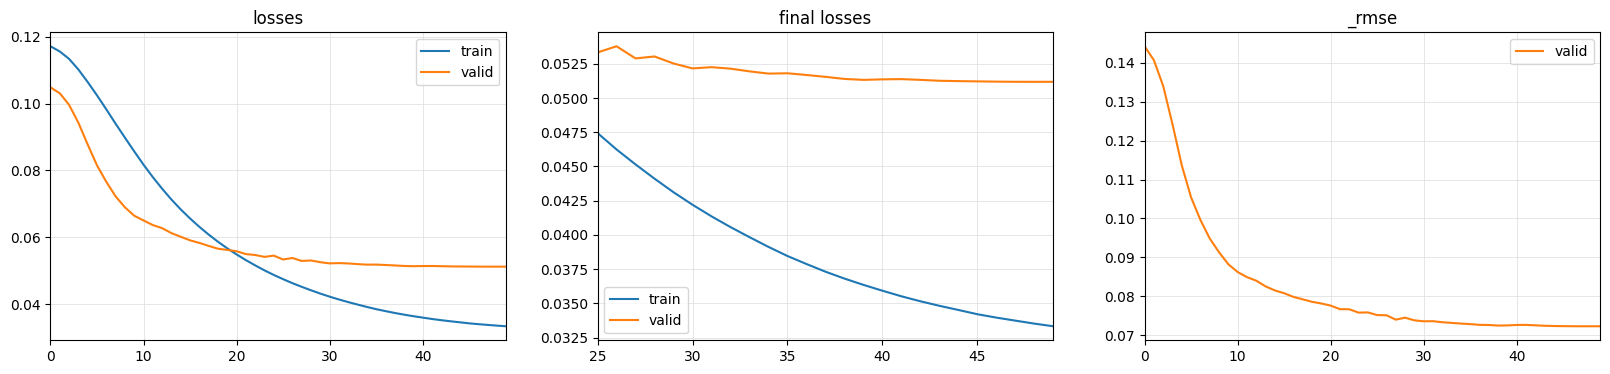

In [56]:
learn.fit_one_cycle(50, lr_max=4e-5)

In [57]:
import datetime

model_name = f"PatchTFT_sh_forecast_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.pth"
torch.save(learn.model, f"../models/{model_name}", pickle_protocol=2)
model_name

'PatchTFT_sh_forecast_20240314023058.pth'

In [59]:
model = torch.load(f'../models/{model_name}', map_location=device)
model.eval()

PatchTST(
  (model): _PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((8, 0))
    (unfold): Unfold(kernel_size=(1, 16), dilation=1, padding=0, stride=8)
    (backbone): _TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (layers): ModuleList(
        (0-1): 2 x _TSTiEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.05, inplace=False)
            )
          )
          (dropout_attn): Dr

In [60]:
import numpy as np

# 单步多次预测
predict_len = 30
pred = []
val = data.values
step = val[-window_length:]
with torch.no_grad():
    for _ in range(predict_len):
        p = torch.from_numpy(step.reshape(-1, dls.vars, dls.len)).type(torch.float).to(device=device)
        p_node = model(p)
        p_node = p_node.cpu().numpy().reshape(horizon, -1)
        step = np.append(step, p_node, axis=0)
        step = step[horizon:, :]
        pred.append(p_node)

pred = np.array(pred)
pred = pd.DataFrame(pred.reshape(-1, dls.vars), columns=data.columns)
for column in pred.columns:
    shape = pred[column].values.shape
    pred[column] = scalers[column].inverse_transform(pred[column].values.reshape(shape[0], -1))

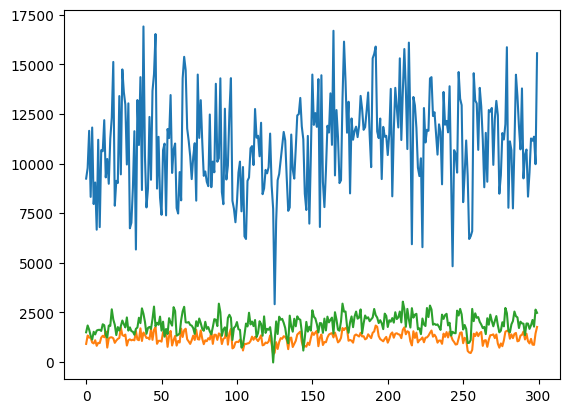

In [61]:
from matplotlib import pyplot as plt

plt.plot(pred)
plt.show()